# Metabolomic autoplier analysis 

In [1]:
import os
import autoplier.model as ap
import autoplier.plot as plot

import pandas as pd
import numpy as np

from functools import reduce

from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

#import csv
#import h5py
#import json
#import matplotlib.pyplot as plt
#import mygene
#from onto_lib import general_ontology_tools as got
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import precision_score, recall_score, average_precision_score
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import MultiLabelBinarizer
#

# Setup

In [13]:
# seed
ap.set_seed_(3306059)

# data path
datadir = os.path.join('..', 'data', 'jdrf')

#results path
resultsdir = os.path.join('..', 'results', 'jdrf')


# Download Data

In [3]:
# - - - - - - Download Data  - - - - - -
#get membership data
membdf=pd.read_csv(os.path.join(datadir, 'membership.csv'), sep=',')
#print(membdf.columns)

#get omics data
omdf=pd.read_csv(os.path.join(datadir, 'Training and validation combined and batch corrected_V3_20190827.csv'), sep=',')
#print(omdf.columns)

#get clinical data
clindf=pd.read_csv(os.path.join(datadir, 'selective clinical data.csv'), sep=',')
#print(clindf.columns)


# Sanity Check Data

In [4]:
# - - - - - - Sanity Check Data  - - - - - -
#replace "CACT" to "CACT1"
omdf.replace("CACT", "CACT1", inplace=True)

#make sure we have the correct cohorts named
assert(all(cohort in np.unique(omdf["cohort"]) for cohort in ['EDC', 'FD', 'STENO','CACT1']))

 # Formatting

In [5]:
#Overload paste function to recover original record ids from the cohort and patient ids
def _reduce_concat(x, sep=""):
    return reduce(lambda x, y: str(x) + sep + str(y), x)
def paste(*lists, sep=" ", collapse=None):
    result = map(lambda x: _reduce_concat(x, sep=sep), zip(*lists))
    if collapse is not None:
        return _reduce_concat(result, sep=collapse)
    return list(result)


In [6]:
#merge cohort and patient id to recover record_id used in clinical data
record_ids = paste(np.repeat("JDRF",len(omdf["cohort"])), omdf["cohort"], sep="_")
record_ids = paste(record_ids, omdf["subject_id"], sep="_")
omdf["record_id"] = record_ids

In [7]:
#drop all ambiguous record_ids
omdf.drop_duplicates(subset='record_id', keep=False, inplace=True, ignore_index=False)

In [8]:
#assert there are no duplicated record_ids
dups = omdf.duplicated("record_id")
assert(np.sum(dups)==0)

# Partition Data

In [9]:
#  - - - - - - Partition Data  - - - - - -
#partition observations by subject id
trainrecs = clindf.loc[clindf["training_or_validation"]=='training']["record_id"]
validrecs = clindf.loc[clindf["training_or_validation"]=='validation']["record_id"]

#get Xtrain and Xvalid
Xtrain = omdf.loc[omdf["record_id"].isin(trainrecs), : ].set_index(["record_id"])
Xvalid = omdf.loc[omdf["record_id"].isin(validrecs), : ].set_index(["record_id"])

#drop uncessary columns
Xtrain.drop(columns=["cohort", "subject_id"], inplace=True)
Xvalid.drop(columns=["cohort", "subject_id"], inplace=True)
#print(Xtrain.columns)
#print(Xvalid.columns)

# - - - - - -  QA/QC  - - - - - -
#remove inf
Xtrain = Xtrain.replace( np.inf , np.nan )
Xvalid = Xvalid.replace( np.inf , np.nan )

#replace NA with half the minimum
Xtrain = Xtrain.replace(np.nan, np.min(Xtrain, axis=0)/2)
Xvalid = Xvalid.replace(np.nan, np.min(Xvalid, axis=0)/2)
#print(Xtrain.isnull().sum())
#print(Xtrain.isnull().sum().sum())

# Omics to pathway transformation

In [10]:
#assert all omics are in the membership data
missingomics =  Xtrain.columns[~(Xtrain.columns.isin(membdf["Standardized.name"])
                                | Xtrain.columns.isin(membdf["Input.name"]))]
if len(missingomics)>2:
    # WARNING: missing omics
    print("the following omics were not found in the membership data.")
    print(missingomics)
assert(len(missingomics)<=2)

In [11]:
#get the standardized omics labels for the columns in X
bigomega = [ membdf.loc[membdf["Input.name"] == metabo, "Standardized.name"].iloc[0]
             if metabo in membdf["Input.name"].values else metabo for metabo in Xtrain.columns]
#print(bigomega)

In [12]:
#order membership data by the omics order (columns of X)
Cmat = membdf.set_index("Standardized.name")
Cmat = Cmat.reindex(bigomega).iloc[:, 8:]
#print(Cmat)

In [14]:
#--- dump formatted xtrain, xvalid, and cmat
Xtrain.to_csv(os.path.join(resultsdir, 'Xtrain.csv'))
Xvalid.to_csv(os.path.join(resultsdir, 'Xvalid.csv'))
Cmat.to_csv(os.path.join(resultsdir, 'Cmat.csv'))
clindf.to_csv(os.path.join(resultsdir, 'clinical.csv'), index=False)


OSError: Cannot save file into a non-existent directory: '../results/jdrf'

In [92]:
#get the known pathway and metbolite classes (Pi) order
bigpi = Cmat.columns
#print(bigpi)

# Autoplier

In [95]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=100, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

In [98]:
# autoplier unsupervized training
def train_autoplier(X, pathways, n_LVs):
    model = ap.autoPLIER(n_LVs, regval = 1.20E-7, learning_rate= 0.000156)
    model.fit(X, pathways, verbose=1, batch_size = None, callbacks = callbacks)
    Z = model.transform(X, pathways)
    
    print(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4))
    
    return Z, model

In [99]:
Z, model = train_autoplier(Xtrain, Cmat, 12)

Epoch 1/2000
13/13 [==============================] - 0s 8ms/step - loss: 4.7992e-06 - magz: 0.0000e+00 - val_loss: 4.5336e-06 - val_magz: 0.0000e+00
Epoch 2/2000
13/13 [==============================] - 0s 2ms/step - loss: 4.5305e-06 - magz: 0.0000e+00 - val_loss: 4.5266e-06 - val_magz: 0.0000e+00
Epoch 3/2000
13/13 [==============================] - 0s 2ms/step - loss: 4.5228e-06 - magz: 0.0000e+00 - val_loss: 4.5180e-06 - val_magz: 0.0000e+00
Epoch 4/2000
13/13 [==============================] - 0s 2ms/step - loss: 4.5136e-06 - magz: 0.0000e+00 - val_loss: 4.5082e-06 - val_magz: 0.0000e+00
Epoch 5/2000
13/13 [==============================] - 0s 2ms/step - loss: 4.5033e-06 - magz: 0.0000e+00 - val_loss: 4.4974e-06 - val_magz: 0.0000e+00
Epoch 6/2000
13/13 [==============================] - 0s 2ms/step - loss: 4.4921e-06 - magz: 0.0000e+00 - val_loss: 4.4858e-06 - val_magz: 0.0000e+00
Epoch 7/2000
13/13 [==============================] - 0s 2ms/step - loss: 4.4802e-06 - magz: 0.0000e

In [16]:
def compare_celltypes(celltype1, celltype2, pathways, seed, n_LVs):
    data_c1 = samples_dummies[celltype1][samples_dummies[celltype1] == 1]
    data_c2 = samples_dummies[celltype2][samples_dummies[celltype2] == 1]
    overlap_1 = ~data_c1.index.isin(data_c2.index)
    overlap_2 = ~data_c2.index.isin(data_c1.index)
    data_c1 = data_c1[overlap_1]
    data_c2 = data_c2[overlap_2]
    Z, model = train_autoplier(CellO_data[CellO_data.index.isin(data_c1.index.union(data_c2.index))], pathways, seed, n_LVs)
    return Z, model

In [17]:
Z, model = compare_celltypes("epithelial cell", "T cell", pathways, 111, 25)
print(Z)

0.9637142857142857
                  0         1         2         3         4    5          6   \
SRX1735869  0.000000  0.000000  0.000000  2.655813  0.000000  0.0   0.000000   
SRX1735868  0.000000  0.000000  0.000000  2.680905  0.000000  0.0   0.000000   
SRX1735863  0.000000  0.000000  0.000000  1.452877  0.000000  0.0   0.000000   
SRX1735862  0.000000  0.000000  0.000000  2.208329  0.000000  0.0   0.000000   
SRX1735867  0.000000  0.000000  0.000000  1.333205  0.000000  0.0   0.000000   
...              ...       ...       ...       ...       ...  ...        ...   
SRX3399287  0.620583  2.221879  1.080988  0.000000  3.464788  0.0  12.302117   
SRX3399288  0.567739  2.256356  1.197575  0.000000  0.976018  0.0  12.637370   
SRX3399289  0.903703  3.285234  1.445535  0.000000  1.108626  0.0  12.836987   
SRX3399290  0.306361  2.478349  1.220616  0.000000  1.491798  0.0  11.783723   
SRX3399291  0.000000  1.447514  0.000000  0.000000  0.000000  0.0  11.075807   

             7      

In [18]:
def classify(Z,celltype1, celltype2, mod):
    data_c1 = samples_dummies[celltype1][samples_dummies[celltype1] == 1]
    data_c2 = samples_dummies[celltype2][samples_dummies[celltype2] == 1]
    overlap_1 = ~data_c1.index.isin(data_c2.index)
    overlap_2 = ~data_c2.index.isin(data_c1.index)
    data_c1 = data_c1[overlap_1]
    data_c2 = data_c2[overlap_2]
    
    X_train = Z[Z.index.isin(data_c1.index.union(data_c2.index))]
    y_train = X_train.index.isin(data_c1.index).astype(int)
    
    pca_mod = PCA(n_components=2)
    X_pca = pca_mod.fit_transform(X_train)
    
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(X_pca[:,0], X_pca[:,1], c = y_train)
    plt.show()
    
    PARAMETERS = {
        'C': [
        0.001, 
        0.01, 
        0.1, 
        1.0,
        10.0,
        100.0
        ]
    }
    MAX_ITER = 200000

    lr_model = LogisticRegression(penalty='l1', solver='liblinear')

    clf = GridSearchCV(lr_model, PARAMETERS, scoring='f1')
    clf.fit(X_train, y_train)

    best_params = max(
        zip(
            clf.cv_results_['param_C'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_C = best_params[0]
    print('Mean test scores:')
    print(clf.cv_results_['mean_test_score'])
    print("Best C chosen: ", best_C)
    
    lr_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C)
    lr_model.fit(X_train, y_train)
    coeffs = lr_model.coef_
    coeffs = coeffs.squeeze()
    print(coeffs)
    
    largest = coeffs.argsort()[-3:]
    smallest = coeffs.argsort()[:3]
    
    largest_vals = [coeffs[x] for x in largest]
    smallest_vals = [coeffs[x] for x in smallest]
    
    print("LVs associated with classification of "+celltype1+" :" )
    print(largest)
    print(largest_vals)
    for lv in largest:
        plot.plot_top_pathways([lv], 5, (10,5), mod)
        plt.title(f'LV {lv}')
        plt.show()
    
    print("LVs associated with classification of "+celltype2+" :" )
    print(smallest)
    print(smallest_vals)
    for lv in smallest:
        plot.plot_top_pathways([lv], 5, (10,5), mod)
        plt.title(f'LV {lv}')

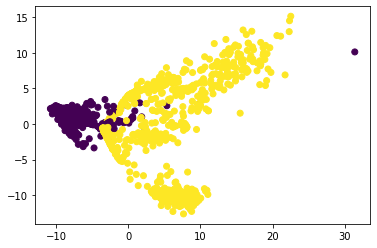

Mean test scores:
[0.92599214 0.98128357 0.98986431 0.99121411 0.98285944 0.97769034]
Best C chosen:  1.0
[-0.01766606  0.          0.          0.         -0.29882397  0.84654761
 -3.96643234  0.         -0.56658098  0.18821212  0.          0.
 -0.2036333   0.34958367  0.          0.          2.16179636  0.
  0.99472633  0.          1.06000599 -0.33532492  0.66097178  0.
  0.        ]
LVs associated with classification of epithelial cell :
[18 20 16]
[0.9947263325689518, 1.0600059885966033, 2.1617963610439914]


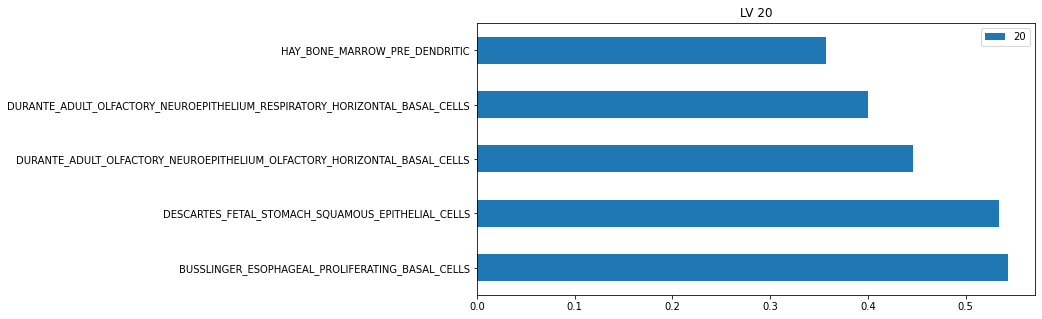

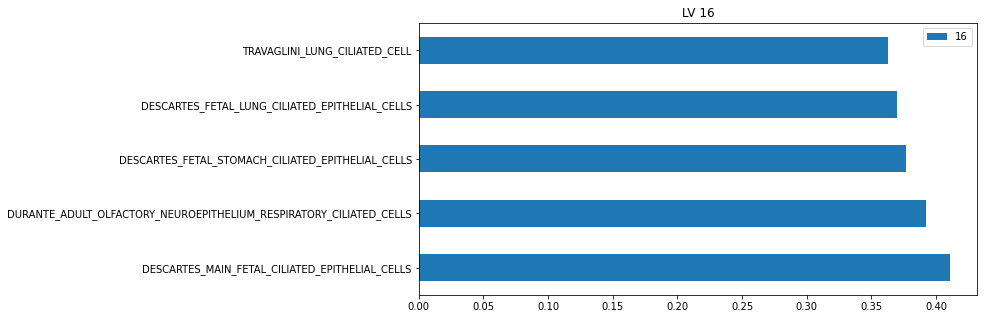

LVs associated with classification of T cell :
[ 6  8 21]
[-3.966432335532006, -0.5665809779937073, -0.3353249188014711]


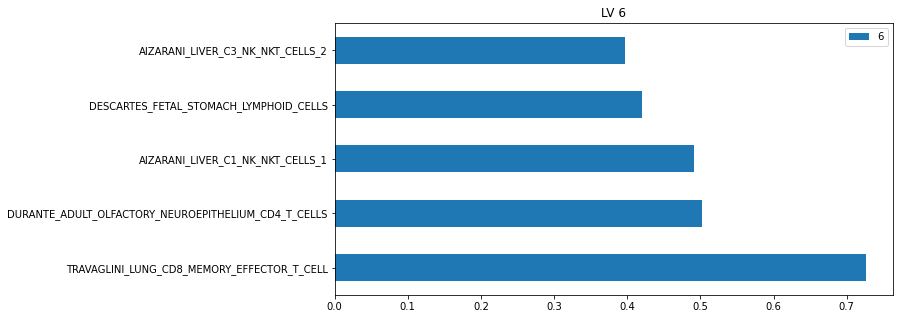

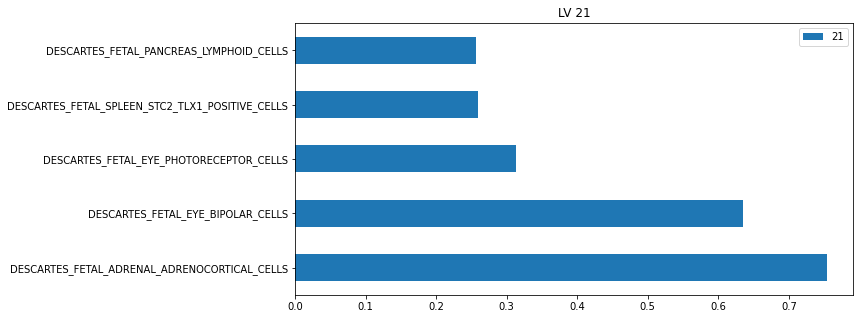

In [19]:
classify(Z,"epithelial cell", "T cell", model)